In [653]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import sklearn
from sklearn.model_selection import cross_val_score, GridSearchCV, KFold
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor 
from sklearn import linear_model
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import AdaBoostRegressor, RandomForestRegressor
from sklearn.metrics import classification_report, mean_squared_error, mean_absolute_error, accuracy_score, r2_score

In [654]:
#Import Data
spy = pd.read_csv('SPY.csv')
qqq = pd.read_csv('QQQ.csv')
spy_price = np.log(spy['Close'])
qqq_price = np.log(qqq['Close'])

#Train, Test split
x = np.array(spy_price)
y = np.array(qqq_price)

In [655]:
#Use a Polynomial Regression with LASSO Regulations to determine spread
from sklearn.preprocessing import PolynomialFeatures
poly = PolynomialFeatures(degree=4, include_bias=False)
poly_features = poly.fit_transform(x_train.reshape(-1, 1))
clf_Lasso = linear_model.Lasso(alpha=0.1) #Lasso
clf_Lasso.fit(poly_features, y_train)

Lasso(alpha=0.1)

Text(0.5, 1.0, 'average R2, cross validation, Lasso')

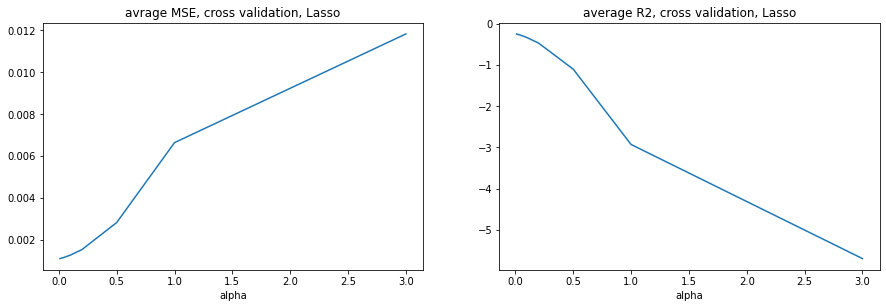

In [656]:
#Hyperparameters tuning, using cross validation
list_of_alpha = [0.01,0.05,0.1,0.2,0.5,1.0,3.0]
MSES_lasso = []
R_sqrs_lasso = []

for i in list_of_alpha:
    clf_Lasso = linear_model.Lasso(alpha=i)
    score1 = cross_val_score(clf_Lasso, poly_features, y_train, cv=5, scoring='neg_mean_squared_error')
    score2 = cross_val_score(clf_Lasso, poly_features, y_train, cv=5, scoring='r2')
    MSES_lasso.append(-sum(score1)/5)
    R_sqrs_lasso.append(sum(score2)/5)

plt.rcParams["figure.figsize"] = (15,10)
plt.subplot(2,2,1)
plt.plot(list_of_alpha, MSES_lasso, label="avrage MSE, cross validation")
plt.xlabel("alpha") 
plt.title("avrage MSE, cross validation, Lasso")

plt.subplot(2,2,2)
plt.plot(list_of_alpha,R_sqrs_lasso, label="average R2, cross validation")
plt.xlabel("alpha") 
plt.title("average R2, cross validation, Lasso")

In [657]:
def get_strategy(x_train, y_train, x_test, y_test):
    #Get standard deviation for historical spread
    poly = PolynomialFeatures(degree=4, include_bias=False)
    poly_features = poly.fit_transform(x_train.reshape(-1, 1))
    clf_Lasso = linear_model.Lasso(alpha=0.05) 
    clf_Lasso.fit(poly_features, y_train)
    y_train_pred = clf_Lasso.predict(poly_features)
    spread = y_train_pred - y_train
    std = np.std(spread)

    #Backtesting
    poly_features = poly.fit_transform(x_test.reshape(-1, 1))
    y_test_pred = clf_Lasso.predict(poly_features)
    #Calculate spread and z-score for testing data
    spread = y_test_pred - y_test
    z_score = spread/std
    z_score = z_score-np.mean(z_score)

    #Get Strategy
    strategy = np.zeros(len(z_score))  
    for i in range(1,len(z_score)):
        if z_score[i] > 0.5 or (strategy[i-1] == -1 and z_score[i] > np.mean(z_score)):
            strategy[i] = -1
            
        elif z_score[i] < -0.5 or (strategy[i-1] == 1 and z_score[i] < np.mean(z_score)):
            strategy[i] = 1 
    
    return z_score, strategy

In [658]:
#Calculate daily returns of the strategy
def calculate_return(strategy, x_test, y_test):
    returns = []
    short = False
    long = False

    for i in range(len(strategy)):
        #Case1: Open Short Position
        if strategy[i] == -1 and not short:
            returns.append(0)
            short = True
          
        #Case2: Open Long Position
        elif strategy[i] == 1 and not long:
            returns.append(0)
            long = True
    
        #Case3: Holding Short Position
        elif short:
            daily_return = 0.5*(x_test[i-1]-x_test[i]) + 0.5*(y_test[i]-y_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                short = False
            else:
                continue
    
        #Case4: Holding Long Position
        elif long:
            daily_return = 0.5*(y_test[i-1]-y_test[i]) + 0.5*(x_test[i]-x_test[i-1])
            returns.append(daily_return)
            #Exit
            if strategy[i] == 0:
                long = False
            else:
                continue
            
        else:
            returns.append(0)
        
    return returns

In [659]:
all_returns = []
all_spread = []
for i in range((len(x)-252)//126):
    x_train, x_test = x[126*i:126*(i+2)], x[126*(i+2):126*(i+3)]
    y_train, y_test = y[126*i:126*(i+2)], y[126*(i+2):126*(i+3)]   
    temp_spread, strategy = get_strategy(x_train, y_train, x_test, y_test)
    temp_returns = calculate_return(strategy, x_test, y_test)
    all_spread.extend(temp_spread)
    all_returns.extend(temp_returns)

x_train, x_remain = x[126*(i+1):126*(i+3)], x[126*(i+3):]
y_train, y_remain = y[126*(i+1):126*(i+3)], y[126*(i+3):]
temp_spread, strategy = get_strategy(x_train, y_train, x_remain, y_remain)
temp_returns = calculate_return(strategy, x_remain, y_remain)
all_returns.extend(temp_returns)
all_spread.extend(temp_spread)

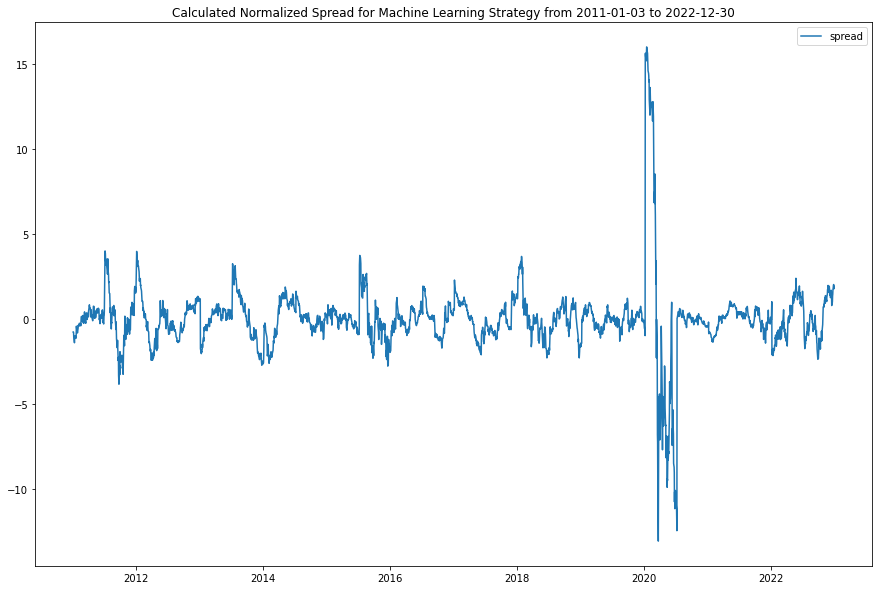

In [665]:
dates = np.asarray(spy['Date'][252:], dtype='datetime64[s]')
plt.plot(dates, all_spread, label = 'spread')
plt.title('Calculated Normalized Spread for Machine Learning Strategy from 2011-01-03 to 2022-12-30')
plt.legend()

/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()


Start date,2011-01-03
End date,2022-12-30
Total months,143
,Backtest
Annual return,5.6%
Cumulative returns,91.9%
Annual volatility,3.4%
Sharpe ratio,1.63
Calmar ratio,1.97
Stability,0.98
Max drawdown,-2.8%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,2.84,2020-03-23,2020-04-09,2020-05-06,33
1,2.69,2022-04-25,2022-12-28,NaT,NaN
2,2.57,2013-11-19,2014-02-18,2014-06-25,157
3,2.41,2011-09-07,2011-09-23,2011-11-10,47
4,2.27,2018-04-03,2018-11-19,2019-03-13,247


/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/opt/anaconda3/lib/python3.8/site-packages/pyfolio/timeseries.py:1228: FutureWarning: Indexing a timezone-aware DatetimeIndex with a timezone-naive datetime is deprecated and will raise KeyError in a future vers

Stress Events,mean,min,max
US downgrade/European Debt Crisis,0.04%,-0.31%,0.52%
Fukushima,-0.00%,-0.27%,0.43%
EZB IR Event,0.04%,-0.22%,0.36%
Apr14,-0.02%,-0.75%,0.54%
Oct14,-0.01%,-0.32%,0.69%
Fall2015,-0.02%,-0.71%,0.57%
Recovery,0.01%,-0.82%,0.99%
New Normal,0.02%,-1.11%,1.22%


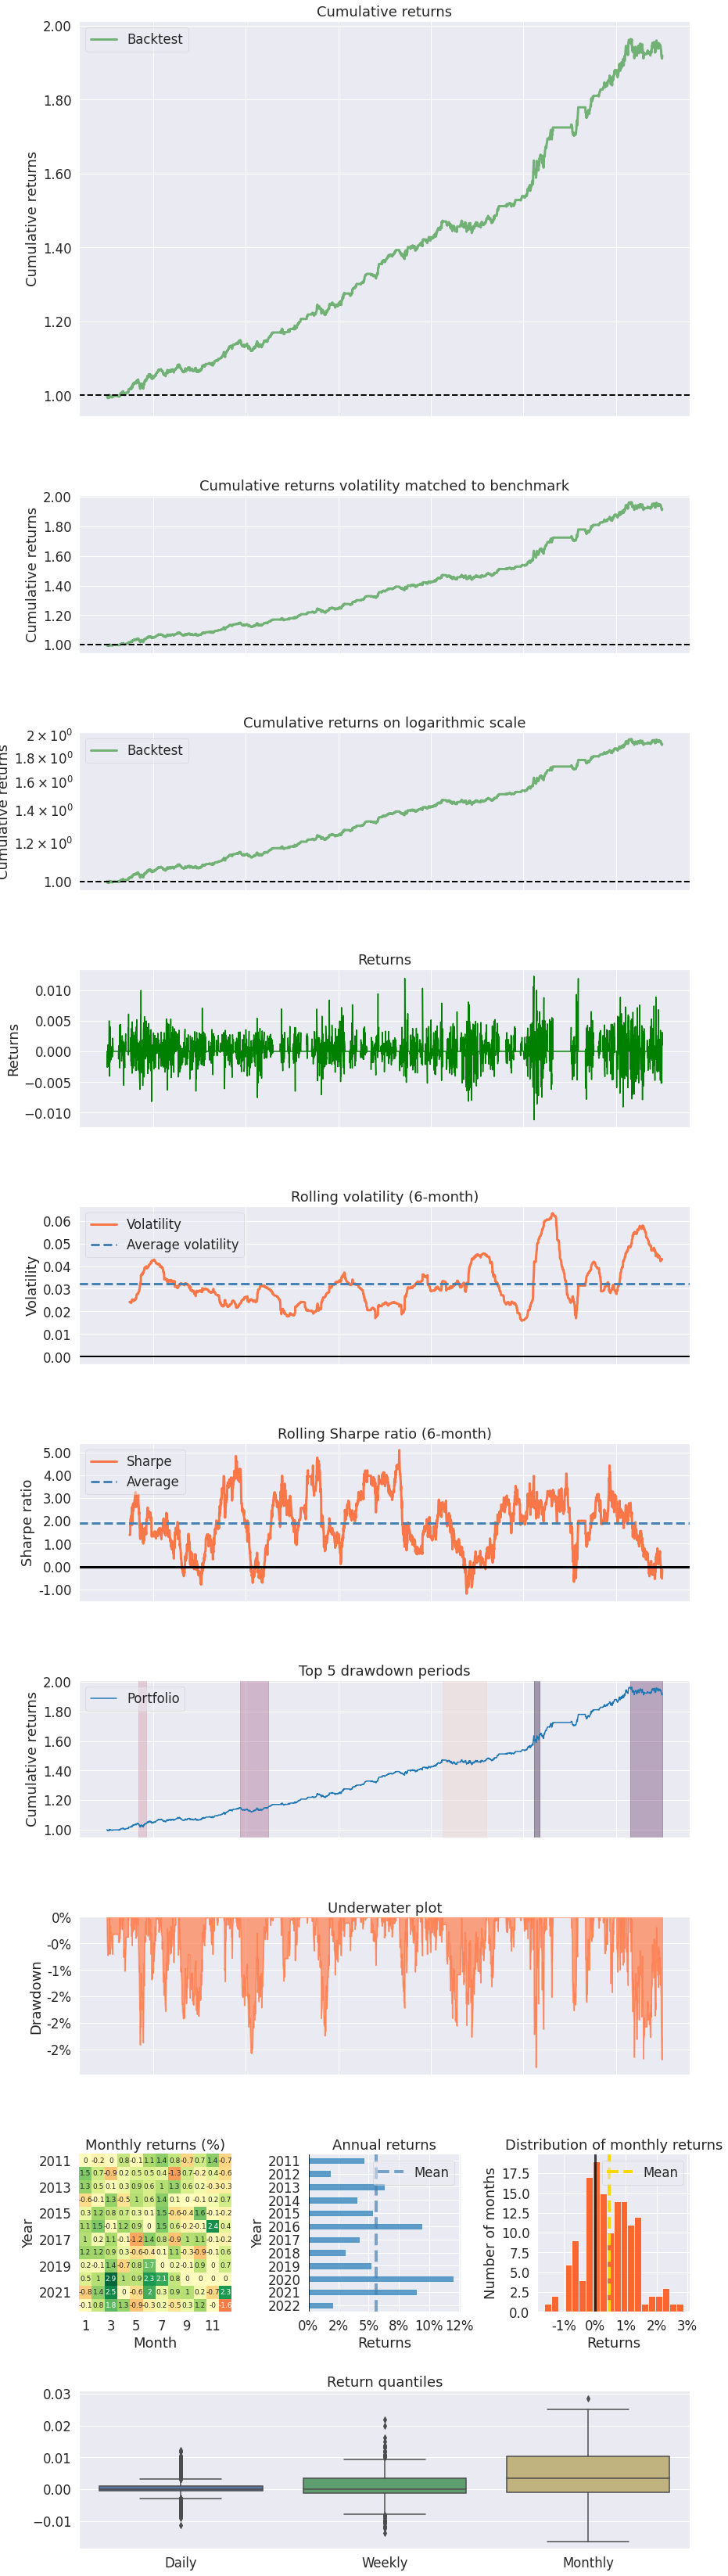

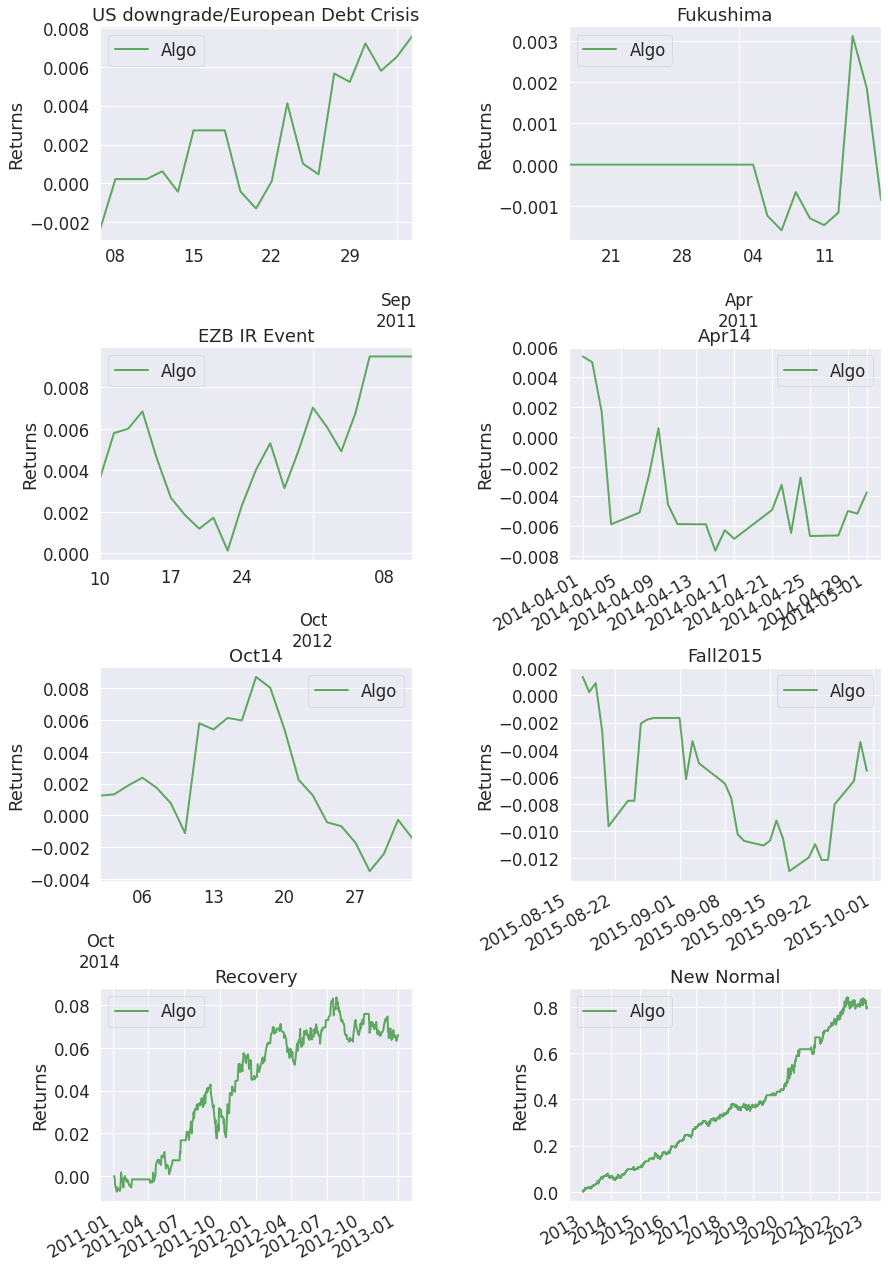

In [661]:
#Backtesting Visualization
import pyfolio as pf
from datetime import datetime
dates = pd.to_datetime(spy['Date'][252:])
rets = pd.Series(data = all_returns, index = dates)
rets = rets.tz_localize('UTC')
#long_only.index = dates
#long_only = long_only.tz_localize('UTC')
pf.create_full_tear_sheet(returns=rets)